# B0822012邱元肇 樣形識別HW8(CH8)

**作業要求:**

依據第九週老師課後所講的作業繳交內容，僅需上傳回去自己試跑的程式與筆記就可以了

**原始程式碼來源:**

https://github.com/fchollet/deep-learning-with-python-notebooks

chapter08_intro-to-dl-for-computer-vision.ipynb


This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to deep learning for computer vision

## Introduction to convnets

**Instantiating a small convnet**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Displaying the model's summary**

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

**Training the convnet on MNIST images**

In [3]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11490434/11490434 [==============================] - 2s 0us/step
Epoch 1/5
938/938 [==============================] - 13s 4ms/step - loss: 0.1575 - accuracy: 0.9521
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0439 - accuracy: 0.9866
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0309 - accuracy: 0.9903
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0228 - accuracy: 0.9932
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0175 - accuracy: 0.9947


**Evaluating the convnet**

In [4]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0302 - accuracy: 0.9905
Test accuracy: 0.990


### The convolution operation

#### Understanding border effects and padding

#### Understanding convolution strides

### The max-pooling operation

**An incorrectly structured convnet missing its max-pooling layers**

In [5]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

## Training a convnet from scratch on a small dataset

### The relevance of deep learning for small-data problems

### Downloading the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yuanchaochiu","key":"3ec5d7e8a226c708e786c2400fb9667c"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:21<00:00, 38.2MB/s]
100% 812M/812M [00:22<00:00, 38.7MB/s]


In [5]:
!unzip -qq /content/sample_data/train.zip

**Copying images to training, validation, and test directories**

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Configuring the model for training**

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [12]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [13]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [14]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [15]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 15s 82ms/step - loss: 0.7622 - accuracy: 0.5185 - val_loss: 0.6909 - val_accuracy: 0.5130
Epoch 2/30
63/63 [==============================] - 5s 71ms/step - loss: 0.7187 - accuracy: 0.5220 - val_loss: 0.6861 - val_accuracy: 0.5560
Epoch 3/30
63/63 [==============================] - 5s 71ms/step - loss: 0.6980 - accuracy: 0.5695 - val_loss: 0.6584 - val_accuracy: 0.5980
Epoch 4/30
63/63 [==============================] - 9s 144ms/step - loss: 0.6601 - accuracy: 0.6285 - val_loss: 0.6139 - val_accuracy: 0.6370
Epoch 5/30
63/63 [==============================] - 5s 70ms/step - loss: 0.6081 - accuracy: 0.6850 - val_loss: 0.6486 - val_accuracy: 0.6270
Epoch 6/30
63/63 [==============================] - 5s 70ms/step - loss: 0.5782 - accuracy: 0.7000 - val_loss: 0.6481 - val_accuracy: 0.6560
Epoch 7/30
63/63 [==============================] - 5s 72ms/step - loss: 0.5396 - accuracy: 0.7480 - val_loss: 0.6108 - val_accuracy: 0.7010
Epoch 8/30


**Displaying curves of loss and accuracy during training**

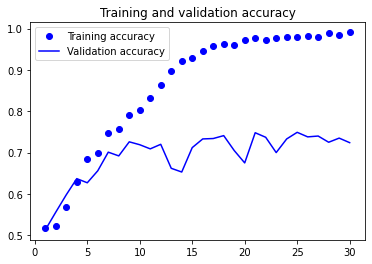

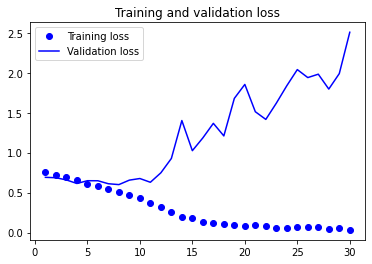

In [17]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [18]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 38ms/step - loss: 0.6010 - accuracy: 0.6955
Test accuracy: 0.696


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

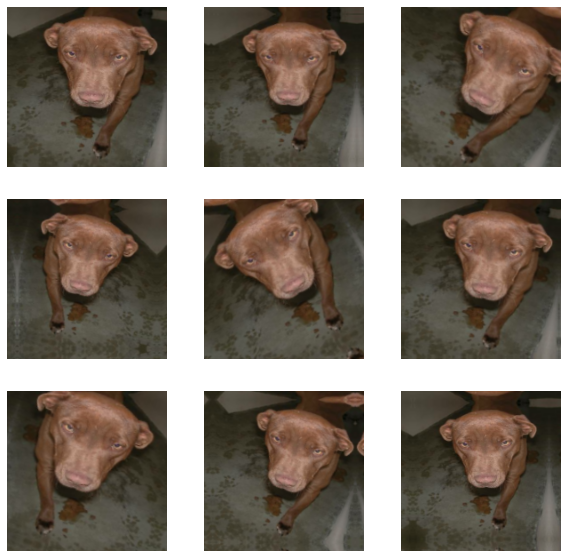

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [21]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 8s 106ms/step - loss: 0.6969 - accuracy: 0.5185 - val_loss: 0.7076 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 8s 118ms/step - loss: 0.6953 - accuracy: 0.5075 - val_loss: 0.7054 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 6s 93ms/step - loss: 0.7054 - accuracy: 0.5760 - val_loss: 0.6862 - val_accuracy: 0.5520
Epoch 4/100
63/63 [==============================] - 6s 93ms/step - loss: 0.6663 - accuracy: 0.6190 - val_loss: 0.6523 - val_accuracy: 0.6060
Epoch 5/100
63/63 [==============================] - 6s 94ms/step - loss: 0.6536 - accuracy: 0.6445 - val_loss: 0.6365 - val_accuracy: 0.6260
Epoch 6/100
63/63 [==============================] - 6s 92ms/step - loss: 0.6320 - accuracy: 0.6650 - val_loss: 0.6894 - val_accuracy: 0.6320
Epoch 7/100
63/63 [==============================] - 6s 92ms/step - loss: 0.6046 - accuracy: 0.6800 - val_loss: 0.6574 - val_accuracy: 0.6110
Epoc

**Evaluating the model on the test set**

In [23]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 36ms/step - loss: 0.4548 - accuracy: 0.8000
Test accuracy: 0.800


## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [24]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [25]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [26]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 19ms/step


In [27]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [28]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 12.9136 - accuracy: 0.9275 - val_loss: 4.6893 - val_accuracy: 0.9690
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 2.8586 - accuracy: 0.9750 - val_loss: 3.8930 - val_accuracy: 0.9680
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 2.7877 - accuracy: 0.9825 - val_loss: 5.8195 - val_accuracy: 0.9660
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 2.2651 - accuracy: 0.9840 - val_loss: 3.3758 - val_accuracy: 0.9760
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6493 - accuracy: 0.9940 - val_loss: 4.4122 - val_accuracy: 0.9750
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.3893 - accuracy: 0.9950 - val_loss: 4.6378 - val_accuracy: 0.9710
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.5456 - accuracy: 0.9945 - val_loss: 5.5716 - val_accuracy: 0.9770
Epoch 8/20
63/63 [

**Plotting the results**

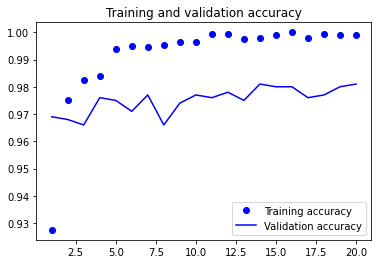

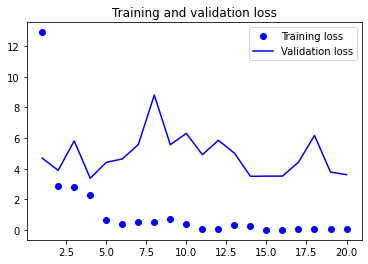

In [29]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [30]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [31]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [32]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [33]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 14s 200ms/step - loss: 17.7157 - accuracy: 0.8930 - val_loss: 3.6173 - val_accuracy: 0.9720
Epoch 2/50
63/63 [==============================] - 12s 194ms/step - loss: 7.9469 - accuracy: 0.9405 - val_loss: 8.4204 - val_accuracy: 0.9620
Epoch 3/50
63/63 [==============================] - 12s 194ms/step - loss: 5.9886 - accuracy: 0.9580 - val_loss: 5.9643 - val_accuracy: 0.9690
Epoch 4/50
63/63 [==============================] - 13s 199ms/step - loss: 3.8193 - accuracy: 0.9685 - val_loss: 3.0528 - val_accuracy: 0.9800
Epoch 5/50
63/63 [==============================] - 13s 196ms/step - loss: 5.0574 - accuracy: 0.9670 - val_loss: 7.1657 - val_accuracy: 0.9620
Epoch 6/50
63/63 [==============================] - 12s 194ms/step - loss: 3.1210 - accuracy: 0.9740 - val_loss: 5.1743 - val_accuracy: 0.9730
Epoch 7/50
63/63 [==============================] - 12s 195ms/step - loss: 3.8957 - accuracy: 0.9680 - val_loss: 4.0313 - val_accuracy: 0.976

**Evaluating the model on the test set**

In [35]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 8s 115ms/step - loss: 2.2842 - accuracy: 0.9760
Test accuracy: 0.976


### Fine-tuning a pretrained model

In [36]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [37]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [38]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 16s 225ms/step - loss: 0.4415 - accuracy: 0.9900 - val_loss: 1.8214 - val_accuracy: 0.9760
Epoch 2/30
63/63 [==============================] - 14s 216ms/step - loss: 0.2110 - accuracy: 0.9940 - val_loss: 2.3643 - val_accuracy: 0.9770
Epoch 3/30
63/63 [==============================] - 14s 214ms/step - loss: 0.5083 - accuracy: 0.9895 - val_loss: 1.8868 - val_accuracy: 0.9780
Epoch 4/30
63/63 [==============================] - 14s 219ms/step - loss: 0.3653 - accuracy: 0.9905 - val_loss: 2.5615 - val_accuracy: 0.9770
Epoch 5/30
63/63 [==============================] - 14s 222ms/step - loss: 0.2225 - accuracy: 0.9915 - val_loss: 1.6637 - val_accuracy: 0.9800
Epoch 6/30
63/63 [==============================] - 14s 216ms/step - loss: 0.3020 - accuracy: 0.9920 - val_loss: 1.9808 - val_accuracy: 0.9790
Epoch 7/30
63/63 [==============================] - 14s 217ms/step - loss: 0.4728 - accuracy: 0.9895 - val_loss: 2.1016 - val_accuracy: 0.9780

In [39]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 8s 113ms/step - loss: 1.5712 - accuracy: 0.9780
Test accuracy: 0.978


## Summary